<font size = "12"> **MEASO space paper** </font>

# Loading relevant libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import UsefulFunctions as uf
import os
import netCDF4 as nc
from collections import OrderedDict
from glob import glob
%matplotlib inline

# Setting up paralellisation prior to analysis

In [2]:
client = Client(n_workers = 12)

# Setting up dictionaries with supporting information for analysis

In [3]:
#This dictionary contains information about each variable to make production of summaries easier
#Change the values of this dictionary as needed
varDict = OrderedDict([
    ('temp', {'model': 'ACCESS-ESM1-5',
              'var_id': 'bigthetao',
              'exp': 'historical', 
              'variant': 'r40i1p1f1',
              'freq': 'mon',
              'long_name': 'water temperature', #Used mainly to label graphs
              'short_name': 'temp', #Used mainly to label graphs
              'means': r'/g/data/v45/la6889/MEASO/Summaries/Temperature/Means',
              'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/Temperature/Percentiles',
              'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/Temperature/StdDev'}),
    ('sal', {'model': 'ACCESS-ESM1-5',
             'var_id': 'so',
             'exp': 'historical', 
             'variant': 'r40i1p1f1',
             'freq': 'mon',
             'long_name': 'water salinity', 
             'short_name': 'sal', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/Salinity/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/Salinity/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/Salinity/StdDev'}),
    ('ph',{'model': 'ACCESS-ESM1-5',
             'var_id': 'ph', #pH
             'exp': 'historical', 
             'variant': 'r40i1p1f1',
             'freq': 'mon',
             'long_name': 'pH', 
             'short_name': 'pH', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/pH/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/pH/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/pH/StdDev'}),
    ('pCO2',{'model': 'ACCESS-ESM1-5',
             'var_id': 'spco2', #Surface Aqueous Partial Pressure of CO2 [Pa] - only surface available
             'exp': 'historical', 
             'variant': 'r40i1p1f1',
             'freq': 'mon',
             'long_name': 'partial CO2 pressure at surface', 
             'short_name': 'pCO2', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/pCO2/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/pCO2/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/pCO2/StdDev'})
])

sea ice concentration:
- siareas - sea ice area South (total area of sea ice in the Southern Hemisphere)
- siextents - sea ice extent South (total area of Southern Hemisphere cells covered by at least 15% areal fraction of sea ice)
- **siconc - sea ice area fraction (% of grid cell covered by ice)**
  
mixed layer depth:
- **mlotst - MLD defined by sigma T (potential density)**. Max and min mean daily values also available.
- omldamax - Ocean MLD defined by mixing scheme. Mean daily maximum

partial CO2 pressure:
- **spco2 - surface partial pressure of CO2 in sea water**

PAR:
- **rsntds - net downward shortwave flux at sea surface**

cloud cover:
- clhcalipso - Cloud area fraction in atmosphere later. % cloud cover in layer centered on 220hPa.


In [ ]:
varDict_fullwatercol = OrderedDict([
    ('mld', {'model': 'ACCESS-ESM1-5',
             'var_id': 'mlotst', #Ocean Mixed Layer Thickness Defined by Sigma T [m]
             'exp': 'historical', 
             'variant': 'r40i1p1f1',
             'freq': 'mon',
             'long_name': 'mixed layer depth', 
             'short_name': 'mld', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/MLD/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/MLD/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/MLD/StdDev'}),
    

])

In [6]:
#This dictionary contains the time periods of interest
periods_interest = {'p1': np.arange(1890, 1911, 10),
                    'p2': np.arange(1940, 1961, 10)}#,
                    # 'p3': np.arange(2000, 2021, 10),
                    # 'p4': np.arange(2040, 2061, 10),
                    # 'p5': np.arange(2090, 2111, 10)}

#This dictionary contains the depths of interest
depths_interest = {'surface': [0, 10],
                   'pelagic': [0, 200],
                   'krill': [0, 400]}

# Using clef to check what data is available in ACCESS-ESM 1.5
The function below, `searchACCESS`, will use the clef library to search databases that meet search requirements set by the user.  
Inputs for `searchACCESS` will define search constraints and can be used to look for variables of interest including area (`areacello`), depth (`thkcello`) and volume (`volcello`) of each pixel.  
Refer to https://github.com/coecms/clef/tree/master/clef/data for information on what variables are accepted by database query function.

In [5]:
#Search clef database
def searchACCESS(var, model, freq, exp, **kwargs):
    '''
    Inputs:
    var - str, code for variable of interest used in CMIP6 models
    model - str, CMIP6 model where variable of interest will be search
    freq - str, requency of the data needed
    
    Optional inputs:
    variant - str, experiment run to be search
    time_frame - list, time period of interest given to the nearest decade 
    (e.g., if interested in the period between 1991 and 2008, then use: [1990, 2000, 2010]
    
    Returns:
    files - list, includes file paths for all datasets that meet search requirements
    within the specified time period
    '''
    
    #Creating a session and connecting to database
    db = connect()
    s = Session()
    
    #Extract variables from kwargs
    if 'variant' in kwargs.keys():
        variant = kwargs.get('variant')
    else:
        variant = None
    
    #Creating dictionary to perform search using clef
    search_dict = {'variable_id': var, 'model': model, 'frequency': freq, 
              'experiment_id':exp, 'variant_label': variant}
    df = search(s, project = 'CMIP6', latest = True, **search_dict)
    
    #If experiment runs (variants) need to be search, use the code below
    # sorted([re.search('r[0-9]{,2}i[0-9]{,2}p[0-9]{,2}f[0-9]{,2}', 
    #                   f).group() for f in df['path']])
    
    if 'time_frame' in kwargs.keys():
        time_frame = kwargs.get('time_frame')
        #Creating a file path list of all available datasets meeting search
        #parameters
        folder_path = [f for f in df['path'] if variant in f]
        filenames = sorted(glob(os.path.join(folder_path[0], '*.nc')))
    
        #Subsetting list to select only files within the time period of interest
        files = []
        for yr in time_frame:
            files.append([f for f in filenames if str(yr) in f][0])
    
    else:
        files = [os.path.join(df['path'][0], list(df['filename'][0])[0])]
    
    return files

In [69]:
from clef.code import *
db = connect()
s = Session()

x = {'variable_id': ['spco2'], 'frequency': ['mon'], 
     'experiment_id': ['historical']}
allvalues = ['variable_id', 'experiment_id']
fixed=['source_id', 'member_id']
res, sel = matching(s, allvalues, fixed, project = 'CMIP6', **x)

In [91]:
from clef.code import *
db = connect()
s = Session()
var = 'pCO2'
y = {'variable_id': varDict[var]['var_id'], 'model': varDict[var]['model'], 'frequency': varDict[var]['freq'],
    'experiment_id': 'historical', 'variant_label': varDict[var]['variant']}
df = search(s, project = 'CMIP6', latest = True, **y)

In [78]:
sorted(glob(os.path.join([f for f in df['path'] if varDict[var]['variant'] in f][0], '*.nc')))

['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r40i1p1f1/Omon/spco2/gn/v20210525/spco2_Omon_ACCESS-ESM1-5_historical_r40i1p1f1_gn_185001-201412.nc']

In [83]:
sorted(glob(os.path.join(df['path'][0], '*.nc')))
# for i in df['path']:
#     print(i)
#[df.experiment_id == 'historical'].variant_label
# set(df.experiment_id)

['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r40i1p1f1/Omon/spco2/gn/v20210525/spco2_Omon_ACCESS-ESM1-5_historical_r40i1p1f1_gn_185001-201412.nc']

In [98]:
#Search data within clef database
def searchACCESS2D(var, model, freq, exp, **kwargs):
    '''
    Inputs:
    var - str, code for variable of interest used in CMIP6 models
    model - str, CMIP6 model where variable of interest will be search
    freq - str, requency of the data needed
    
    Optional inputs:
    variant - str, experiment run to be search
    time_frame - list, time period of interest given to the nearest decade 
    (e.g., if interested in the period between 1991 and 2008, then use: [1990, 2000, 2010]
    
    Returns:
    files - list, includes file paths for all datasets that meet search requirements
    within the specified time period
    '''
    
    #Creating a session and connecting to database
    db = connect()
    s = Session()
    
    #Extract variables from kwargs
    if 'variant' in kwargs.keys():
        variant = kwargs.get('variant')
    else:
        variant = None
    
    #Creating dictionary to perform search using clef
    search_dict = {'variable_id': var, 'model': model, 'frequency': freq, 
              'experiment_id':exp, 'variant_label': variant}
    df = search(s, project = 'CMIP6', latest = True, **search_dict)
    
    #If experiment runs (variants) need to be search, use the code below
    # sorted([re.search('r[0-9]{,2}i[0-9]{,2}p[0-9]{,2}f[0-9]{,2}', 
    #                   f).group() for f in df['path']])
    files = sorted(glob(os.path.join(df['path'][0], '*.nc')))
    
    return files

In [96]:
# files =  sorted(glob(os.path.join(df['path'][0], '*.nc')))
# x = xr.open_dataset(files[0], mask_and_scale = True)

x[varDict[var]['var_id']]

<xarray.DataArray 'spco2' (time: 1980, j: 300, i: 360)>
[213840000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
    depth      float64 0.0
Attributes:
    standard_name:  surface_partial_pressure_of_carbon_dioxide_in_sea_water
    long_name:      Surface Aqueous Partial Pressure of CO2
    comment:        The surface called 'surface' means the lower boundary of ...
    units:          Pa
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2021-05-25T07:41:42Z altered by CMOR: Treated scalar dime...

## Checking data structure prior to further processing (Optional step)

In [100]:
var = nc.Dataset(filepath)
print(var)
print(var.__dict__)
[print(dim) for dim in var.dimensions.values()]
[print(var) for var in var.variables.values()]

# Applying functions

## Declaring set up variables before extracting data and calculating summaries

In [99]:
var = 'pCO2'
percentiles = [.2, .4, .5, .6, .8]
months = ['07', '06']

## Creating mask with regions of interest
Create a mask using a netcdf file with the `creatingMask` function. Masks can be created from shapefiles using the `0_CreatingMeasoMask.ipynb` notebook.

In [100]:
MEASOregions, regionNames = uf.creatingMask('MEASO_3Dmask.nc')

## Accessing data that will be used as weights
ACCESS-ESM-1.5 has the following variables that could be used as weights in summary calculations:
- area (`areacello`)
- depth (`thkcello`)
- volume (`volcello`)  
  
All the variables above provide data for each pixel in the area of interest.

In [7]:
#Accessing data
#Volume per pixel - For weighting
vol_file = uf.searchACCESS(var = 'volcello',
                        model = varDict[var]['model'], 
                        freq = varDict[var]['freq'], 
                        exp = varDict[var]['exp'], 
                        variant = varDict[var]['variant'])

## Applying functions to calculate summaries

In [102]:
for depth in depths_interest:
    #Creating paths to save data and ensuring they exist
    mean_path_out = os.path.join(varDict[var]['means'], depth.title())
    os.makedirs(mean_path_out, exist_ok = True)
    std_path_out = os.path.join(varDict[var]['std_dev'], depth.title())
    os.makedirs(std_path_out, exist_ok = True)
    per_path_out = os.path.join(varDict[var]['percentiles'], depth.title())
    os.makedirs(per_path_out, exist_ok = True)

    #Loading volume data
    vol_df = uf.loadData(filelist = vol_file, 
                      var_name = 'volcello',
                      SO = True, 
                      depth_range = depths_interest[depth])

    for per in periods_interest:
        years = periods_interest[per]
        #Searching variable of interest in database
        # var_int = uf.searchACCESS(var = varDict[var]['var_id'], 
        var_int = searchACCESS2D(var = varDict[var]['var_id'], 
                               model = varDict[var]['model'], 
                               freq = varDict[var]['freq'], 
                               exp = varDict[var]['exp'], 
                               time_frame = years, 
                               variant = varDict[var]['variant'])
        # Loading variable of interest for each time period and depth of interest
        var_df = uf.loadData(filelist = var_int, 
                          var_name = varDict[var]['var_id'],
                          SO = True, depth_range = depths_interest[depth],
                          years = years, 
                          months = months)

        #Calculate weighted means
        weightedvarMeans = uf.weightedMeans(regions = regionNames, 
                                         var_df = var_df, 
                                         mask_df =  MEASOregions, 
                                         weights = vol_df)
        #Create filename
        file_out_m = os.path.join(mean_path_out, 
                                f'WeightedMonthlyMeans_{var}_{depth}_{years[0]}-{years[-1]}.nc')
        #Save file
        weightedvarMeans.to_netcdf(file_out_m)

        #Calculate weighted and unweighted standard deviation
        un_std_calcs, w_std_calcs = uf.std_dev(regions = regionNames,
                                            var_df = var_df, 
                                            mask_df =  MEASOregions, 
                                            weights = vol_df,
                                            weighted_means = weightedvarMeans)
        # #Create filename
        file_out_w = os.path.join(std_path_out, 
                                  f'WeightedMonthlyMeans_{var}_{depth}_{years[0]}-{years[-1]}.nc')
        file_out_u = os.path.join(std_path_out, 
                                  f'UnweightedMonthlyMeans_{var}_{depth}_{years[0]}-{years[-1]}.nc')
        #Save file
        w_std_calcs.to_netcdf(file_out_w)
        un_std_calcs.to_netcdf(file_out_u)

        #Calculate percentiles
        per_calcs = uf.perc_calc(regions = regionNames,
                              var_df = var_df, 
                              mask_df =  MEASOregions, 
                              percentiles = percentiles)
        #Create filename
        file_out_p = os.path.join(per_path_out, 
                                f'MonthlyPercentiles_{var}_{depth}_{years[0]}-{years[-1]}.nc')
        #Save file
        per_calcs.to_netcdf(file_out_p)

KeyError: 'spco2'

In [108]:
# uf.loadData(filelist = var_int, 
#                           var_name = varDict[var]['var_id'],
#                           SO = True, depth_range = depths_interest[depth],
#                           years = years, 
#                           months = months)
var_name = varDict[var]['var_id']
x= []
if len(var_int) > 1:
    #Looping through files and stacking them
    for f in var_int:
        x.append(xr.open_dataset(f, mask_and_scale = True))
    #Concatenating files across time dimension
    x = xr.concat(x, dim = 'time')
else:
    x = xr.open_dataset(var_int[0], mask_and_scale = True)
    x = x[var_name][0]

In [109]:
x

<xarray.DataArray 'spco2' (j: 300, i: 360)>
[108000 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 1850-01-16T12:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
    depth      float64 ...
Attributes:
    standard_name:  surface_partial_pressure_of_carbon_dioxide_in_sea_water
    long_name:      Surface Aqueous Partial Pressure of CO2
    comment:        The surface called 'surface' means the lower boundary of ...
    units:          Pa
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2021-05-25T07:41:42Z altered by CMOR: Treated scalar dime...

# Extracting summaries using 2D MEASO mask

## Loading 2D mask

In [12]:
regions2D = xr.load_dataarray('MEASO_2Dmask.nc')
regions2D

<xarray.DataArray 'region' (latitude: 77, longitude: 360)>
array([[ 1.,  1.,  1., ..., 26., 26., 26.],
       [ 1.,  1.,  1., ..., 26., 26., 26.],
       [ 1.,  1.,  1., ..., 26., 26., 26.],
       ...,
       [ 5.,  5.,  5., ..., 31., 31., 31.],
       [ 5.,  5.,  5., ..., 31., 31., 31.],
       [ 5.,  5.,  5., ..., 31., 31., 31.]])
Coordinates:
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

In [78]:
#Loading region keys 
region_key = pd.read_csv('/g/data/v45/la6889/MEASO/MEASO_RegionKeys.csv')
region_key

,Region_ID,Region_name
0,0.0,WPA-O
1,1.0,WPA-N
2,3.0,WPS
3,4.0,WPN
4,5.0,WPT
5,6.0,EPA-N
6,7.0,EPA-O
7,8.0,EPS
8,9.0,EPN
9,10.0,EPT


## Applying mask to regional calculations

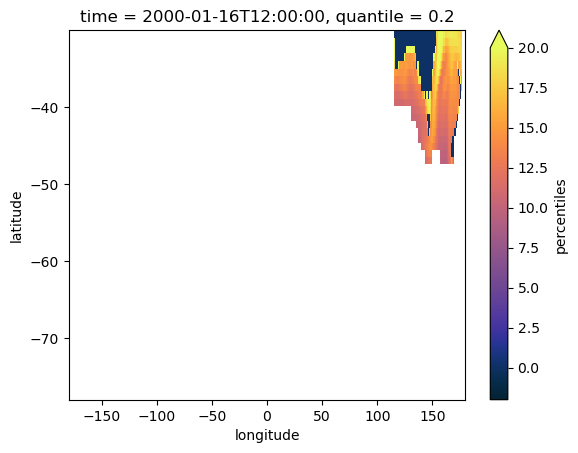

In [84]:
#Let's suppose we want to access the 20th percentile for the EIT region (value of 25 in mask)
#Showing the first time step only
per_temp.where(regions2D == 25).sel(quantile = 0.2)[0].plot(cmap = cm.cm.thermal, 
                                                            vmin = -2, vmax = 20)

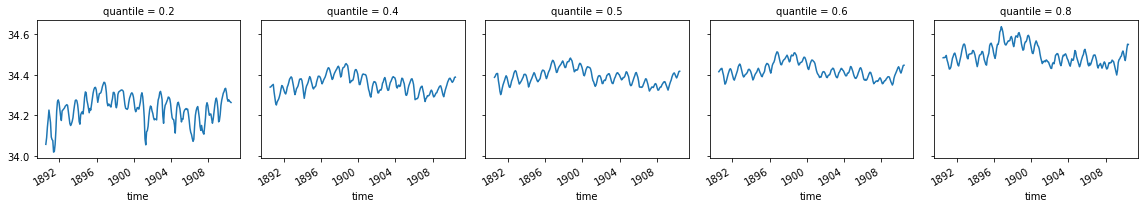

In [131]:
per_calcs.sel(region = 'AOA-N').plot(col = 'quantile')